<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/BAFV2data_preprocessing2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import random
import os
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.utils import resample

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'


Mounted at /content/drive


# LOAD DATA & MODEL

In [69]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}


Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


load best light gbm model from variant 2

In [70]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model for variant 2
modelv2 = models.get("model_Variant II_top_4")

print(modelv2)

Model 'model_Variant II_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant II_top_4.pkl
Model 'model_Variant V_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant V_top_0.pkl
Model 'model_Variant I_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant I_top_4.pkl
Model 'model_Variant IV_top_6' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant IV_top_6.pkl
Model 'model_Variant III_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant III_top_0.pkl
Model 'model_Base_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Base_top_4.pkl
LGBMClassifier(boo

# Explore data

In [71]:
#rename dataset variant 2 and create a copy
v2 = dataframes["Variant II"]
v2_old = v2.copy()

In [72]:
pd.set_option('display.max_columns', 50) # Increase the maximum number of columns displayed in Pandas to 50
pd.set_option('display.max_rows', 50)
v2.iloc[3]

,3
fraud_bool,0
income,0.3
name_email_similarity,0.059078
prev_address_months_count,10
current_address_months_count,40
customer_age,60
days_since_request,0.008007
intended_balcon_amount,-0.075908
payment_type,AA
zip_count_4w,1697


In [73]:
v2['payment_type'].unique() #remove because obfuscated
v2['days_since_request'].unique() #remove because unclear values

array([0.01673985, 0.01900183, 0.04706417, ..., 0.03555377, 0.02066269,
       0.0074784 ])

In [74]:
print(v2['days_since_request'])

0         0.016740
1         0.019002
2         0.047064
3         0.008007
4         2.513544
            ...   
999995    0.001835
999996    0.023952
999997    0.035554
999998    0.020663
999999    0.007478
Name: days_since_request, Length: 1000000, dtype: float64


In [75]:
v2_old['source'].unique()
v2_old['device_os'].unique()
v2_old['keep_alive_session'].unique()
#v2_old['device_fraud_count'].unique()

array([0, 1])

In [76]:
1 in v2_old['device_fraud_count'].unique()

False

In [77]:
v2_old['device_os'].unique()

array(['other', 'macintosh', 'linux', 'windows', 'x11'], dtype=object)

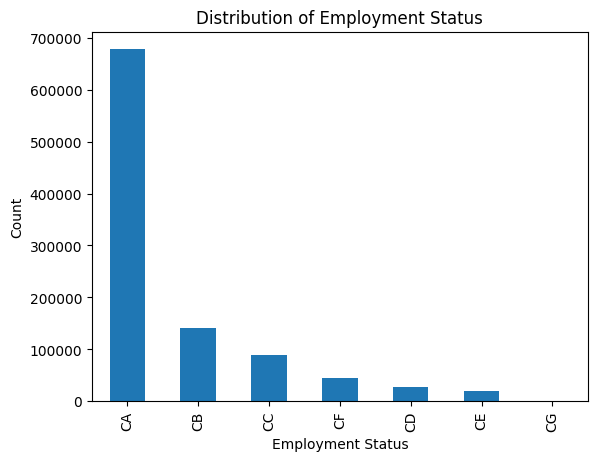

In [78]:
v2_old['employment_status'].value_counts().plot(kind='bar')
plt.title('Distribution of Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.show()

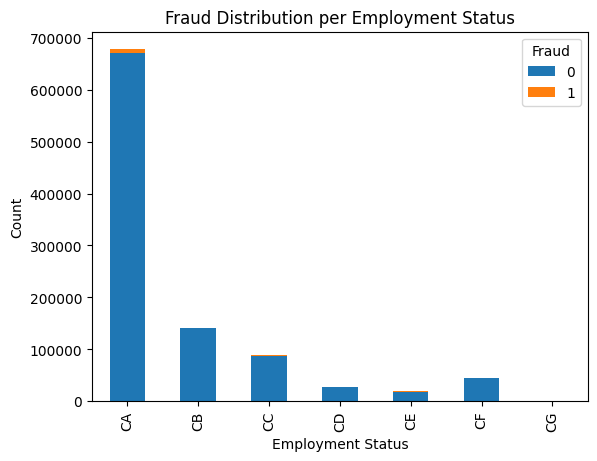

In [79]:
fraud_per_employment = v2_old.groupby(['employment_status', 'fraud_bool']).size().unstack()

fraud_per_employment.plot(kind='bar', stacked=True)
plt.title('Fraud Distribution per Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.legend(title='Fraud')  # Add a legend to indicate fraud (0 or 1)
plt.show()

Master dataset

In [80]:
#Master dataset
#FEATURES
META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = [ 'session_length_in_minutes', 'email_is_free',
       'proposed_credit_limit','name_email_similarity',
      'zip_count_4w', 'date_of_birth_distinct_emails_4w',
      'phone_mobile_valid', 'has_other_cards', 'foreign_request']
SEN = ['customer_age', 'income'] #protected attributes in BAF paper also employment_status
DUMMY = ['source_INTERNET', 'source_TELEAPP', 'device_os_other', 'device_os_macintosh','device_os_linux','device_os_windows', 'device_os_x11']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['session_length_in_minutes_scaled',
              'email_is_free_scaled',
              'proposed_credit_limit_scaled',
              'name_email_similarity_scaled',
              'zip_count_4w_scaled',
              'date_of_birth_distinct_emails_4w_scaled','has_other_cards_scaled', 'foreign_request_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled']
DUMMY_scaled = ['source_INTERNET_scaled', 'source_TELEAPP_scaled', 'device_os_other_scaled', 'device_os_macintosh_scaled', 'device_os_linux_scaled', 'device_os_windows_scaled', 'device_os_x11_scaled']


#SHAP FEATURES
SHAP_REG = [
    'Shap_session_length_in_minutes', 'Shap_email_is_free',
    'Shap_proposed_credit_limit', 'Shap_name_email_similarity',
    'Shap_zip_count_4w', 'Shap_date_of_birth_distinct_emails_4w',
    'Shap_phone_mobile_valid', 'Shap_has_other_cards', 'Shap_foreign_request'
]

SHAP_SEN = ['Shap_customer_age', 'Shap_income']

SHAP_DUMMY = [
    'Shap_source_INTERNET', 'Shap_source_TELEAPP',
    'Shap_device_os_other', 'Shap_device_os_macintosh',
    'Shap_device_os_linux', 'Shap_device_os_windows', 'Shap_device_os_x11'
]

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_session_length_in_minutes_scaled',
    'Shap_email_is_free_scaled', 'Shap_proposed_credit_limit_scaled',
    'Shap_name_email_similarity_scaled', 'Shap_zip_count_4w_scaled',
    'Shap_date_of_birth_distinct_emails_4w_scaled',
    'Shap_phone_mobile_valid_scaled', 'Shap_has_other_cards_scaled',
    'Shap_foreign_request_scaled'
]

SHAP_SEN_scaled = ['Shap_customer_age_scaled', 'Shap_income_scaled']

SHAP_DUMMY_scaled = [
    'Shap_source_INTERNET_scaled', 'Shap_source_TELEAPP_scaled',
    'Shap_device_os_other_scaled', 'Shap_device_os_macintosh_scaled',
    'Shap_device_os_linux_scaled', 'Shap_device_os_windows_scaled',
    'Shap_device_os_x11_scaled'
]

'''removed features = 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',
'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',
'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', '''

"removed features = 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',\n'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',\n'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', "

In [81]:
#v2_old['housing_status'].unique()
#v2_old['employment_status'].unique()
#v2_old['source'].unique()
v2_old['device_os'].unique()

array(['other', 'macintosh', 'linux', 'windows', 'x11'], dtype=object)

Remove features

In [82]:
features_to_remove = ['device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',
'velocity_6h','velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',
'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status', 'bank_branch_count_8w', 'credit_risk_score', 'month']
v2 = v2.drop(columns = features_to_remove)

In [83]:
v2.iloc[3]

,3
fraud_bool,0
income,0.3
name_email_similarity,0.059078
customer_age,60
zip_count_4w,1697
date_of_birth_distinct_emails_4w,14
email_is_free,1
phone_mobile_valid,1
has_other_cards,1
proposed_credit_limit,200.0


In [84]:
#get a smaller sample approx like compas
v2_sample = v2.sample(n= 8000, random_state = 42)

In [85]:
v2_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 987231 to 534950
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fraud_bool                        8000 non-null   int64  
 1   income                            8000 non-null   float64
 2   name_email_similarity             8000 non-null   float64
 3   customer_age                      8000 non-null   int64  
 4   zip_count_4w                      8000 non-null   int64  
 5   date_of_birth_distinct_emails_4w  8000 non-null   int64  
 6   email_is_free                     8000 non-null   int64  
 7   phone_mobile_valid                8000 non-null   int64  
 8   has_other_cards                   8000 non-null   int64  
 9   proposed_credit_limit             8000 non-null   float64
 10  foreign_request                   8000 non-null   int64  
 11  source                            8000 non-null   object 
 12  sess

In [86]:
'''missing_values = v2_sample.isna()
print(missing_values)'''

'missing_values = v2_sample.isna()\nprint(missing_values)'

Get dummies for objects

In [87]:
dummy_cols = ['source', 'device_os']
v2_sample = pd.get_dummies(v2_sample, columns = dummy_cols)
v2_sample.iloc()

In [88]:
v2_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 987231 to 534950
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fraud_bool                        8000 non-null   int64  
 1   income                            8000 non-null   float64
 2   name_email_similarity             8000 non-null   float64
 3   customer_age                      8000 non-null   int64  
 4   zip_count_4w                      8000 non-null   int64  
 5   date_of_birth_distinct_emails_4w  8000 non-null   int64  
 6   email_is_free                     8000 non-null   int64  
 7   phone_mobile_valid                8000 non-null   int64  
 8   has_other_cards                   8000 non-null   int64  
 9   proposed_credit_limit             8000 non-null   float64
 10  foreign_request                   8000 non-null   int64  
 11  session_length_in_minutes         8000 non-null   float64
 12  sour

# Train RF

In [89]:
#separate features and target
X = v2_sample.drop(columns = ['fraud_bool'], axis = 1)
Y = v2_sample['fraud_bool']
Y.value_counts()

,count
fraud_bool,
0,7918
1,82


In [90]:
#Change booleans to numeric for SHAP compatability
X = X.astype(int)
Y = Y.astype(int)
X.iloc[7]

,732057
income,0
name_email_similarity,0
customer_age,20
zip_count_4w,990
date_of_birth_distinct_emails_4w,6
email_is_free,1
phone_mobile_valid,1
has_other_cards,1
proposed_credit_limit,500
foreign_request,0


Upsample for more frauds

In [91]:
# Separate majority and minority classes
df_majority = v2_sample[v2_sample['fraud_bool'] == 0]
df_minority = v2_sample[v2_sample['fraud_bool'] == 1]

# Define the desired ratio
minority_ratio = 0.5  # Aim for equal classes
n_samples = int(minority_ratio * len(df_majority) / (1 - minority_ratio))

# Perform upsampling
df_minority_upsampled = resample(df_minority, replace=True, n_samples=n_samples, random_state=42)

# Combine the datasets
v2_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check new class distribution
print("New class distribution:")
print(v2_upsampled['fraud_bool'].value_counts())

New class distribution:
fraud_bool
0    7918
1    7918
Name: count, dtype: int64


In [97]:
v2_upsampled = v2_upsampled.astype(int)
v2_upsampled.iloc[3]

,500891
fraud_bool,0
income,0
name_email_similarity,0
customer_age,50
zip_count_4w,916
date_of_birth_distinct_emails_4w,2
email_is_free,1
phone_mobile_valid,1
has_other_cards,0
proposed_credit_limit,200


In [98]:
#prepare upsampled train-test split
X_upsampled = v2_upsampled.drop(columns=['fraud_bool'])
Y_upsampled = v2_upsampled['fraud_bool']

Y_upsampled.value_counts()

,count
fraud_bool,
0,7918
1,7918


In [99]:
X_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15836 entries, 987231 to 496375
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   income                            15836 non-null  int64
 1   name_email_similarity             15836 non-null  int64
 2   customer_age                      15836 non-null  int64
 3   zip_count_4w                      15836 non-null  int64
 4   date_of_birth_distinct_emails_4w  15836 non-null  int64
 5   email_is_free                     15836 non-null  int64
 6   phone_mobile_valid                15836 non-null  int64
 7   has_other_cards                   15836 non-null  int64
 8   proposed_credit_limit             15836 non-null  int64
 9   foreign_request                   15836 non-null  int64
 10  session_length_in_minutes         15836 non-null  int64
 11  source_INTERNET                   15836 non-null  int64
 12  source_TELEAPP                 

In [118]:
# Create train and test sets based on 'month'
'''X_train = X_upsampled[X_upsampled['month'] < 6]
Y_train = Y_upsampled[Y_upsampled['month'] < 6]
X_test = X_upsampled[X_upsampled['month'] >= 6]
Y_test = Y_upsampled[Y_upsampled['month'] >= 6]'''

X_train, X_test, Y_train, Y_test = train_test_split(X_upsampled, Y_upsampled, #test_size=0.2,
                                                    test_size = 0.7, shuffle = True, stratify = Y_upsampled)

print("Class distribution in Y_train after upsampling:")
print(Y_train.value_counts())

Class distribution in Y_train after upsampling:
fraud_bool
0    2375
1    2375
Name: count, dtype: int64


In [120]:
#X_test.info()

In [121]:
#X_train.info()

In [122]:
X_df = pd.concat([X_train, X_test])
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15836 entries, 238749 to 900541
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   income                            15836 non-null  int64
 1   name_email_similarity             15836 non-null  int64
 2   customer_age                      15836 non-null  int64
 3   zip_count_4w                      15836 non-null  int64
 4   date_of_birth_distinct_emails_4w  15836 non-null  int64
 5   email_is_free                     15836 non-null  int64
 6   phone_mobile_valid                15836 non-null  int64
 7   has_other_cards                   15836 non-null  int64
 8   proposed_credit_limit             15836 non-null  int64
 9   foreign_request                   15836 non-null  int64
 10  session_length_in_minutes         15836 non-null  int64
 11  source_INTERNET                   15836 non-null  int64
 12  source_TELEAPP                 

Create scaled versions of the features

In [123]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
X_scaled_df = pd.concat([pd.DataFrame(X_scaled_train, columns=[col + '_scaled' for col in X_upsampled.columns]),
                         pd.DataFrame(X_scaled_test, columns=[col + '_scaled' for col in X_upsampled.columns])])


In [124]:
#merge scaled and unscaled data
v2_upsampled_scaled = pd.merge(v2_upsampled, X_scaled_df, left_index=True, right_index=True)
v2_upsampled_scaled.info()
v2_upsampled_scaled.iloc[3]

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 2085 to 9221
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fraud_bool                               329 non-null    int64  
 1   income                                   329 non-null    int64  
 2   name_email_similarity                    329 non-null    int64  
 3   customer_age                             329 non-null    int64  
 4   zip_count_4w                             329 non-null    int64  
 5   date_of_birth_distinct_emails_4w         329 non-null    int64  
 6   email_is_free                            329 non-null    int64  
 7   phone_mobile_valid                       329 non-null    int64  
 8   has_other_cards                          329 non-null    int64  
 9   proposed_credit_limit                    329 non-null    int64  
 10  foreign_request                          329 non-nu

,6298
fraud_bool,0.000000
income,0.000000
name_email_similarity,0.000000
customer_age,20.000000
zip_count_4w,1744.000000
date_of_birth_distinct_emails_4w,22.000000
email_is_free,1.000000
phone_mobile_valid,1.000000
has_other_cards,0.000000
proposed_credit_limit,200.000000


Train on scaled X (unnecessary for RF but good for SHAP later on)

In [125]:
#model = modelv2 #original 'best' light gbm model
model = RandomForestClassifier(
    n_estimators=30, #reducing nr of trees for more errors
    max_depth=3, #limiting the depth of trees
    class_weight= None,
    random_state=42
)
model.fit(X_scaled_train, Y_train)


#predictions
Yhat = model.predict(X_scaled_test)
len(Yhat)

11086

# Add Errors

In [126]:
X_scaled_test

array([[ 0.        ,  0.        , -1.23147871, ...,  2.05003139,
        -0.9627968 , -0.0977972 ],
       [ 0.        ,  0.        , -1.9818987 , ..., -0.48779741,
        -0.9627968 , -0.0977972 ],
       [ 0.        ,  0.        ,  1.01978128, ..., -0.48779741,
        -0.9627968 , -0.0977972 ],
       ...,
       [ 0.        ,  0.        ,  0.26936128, ..., -0.48779741,
         1.03864075, -0.0977972 ],
       [ 0.        ,  0.        , -1.9818987 , ...,  2.05003139,
        -0.9627968 , -0.0977972 ],
       [ 0.        ,  0.        ,  1.01978128, ..., -0.48779741,
        -0.9627968 , -0.0977972 ]])

In [127]:
#Create df for predicted, true classes and errors
predictions = pd.DataFrame({
    'predicted_class': Yhat.tolist(),
    'true_class': Y_test.values,
    'errors': abs(Yhat - Y_test.values)
}, index=X_test.index)

#adding predictions to test data
X_scaled_test_df = pd.DataFrame(X_scaled_test, columns=[col + '_scaled' for col in X_test.columns], index=X_test.index)
# Reset index and drop the old index column for all DataFrames
X_scaled_test_df = X_scaled_test_df.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
predictions = predictions.reset_index(drop=True)

# Concatenate the dataframes
V2_error = pd.concat([X_test, X_scaled_test_df, predictions], axis=1)


errors = V2_error['errors']
df_out = V2_error.drop(['predicted_class', 'true_class', 'errors'], axis=1)
V2_error[V2_error['errors']==1]

#accuracy & confusion matrix
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)

Accuracy: 0.7522
[[4222 1321]
 [1426 4117]]


In [128]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   predicted_class  11086 non-null  int64
 1   true_class       11086 non-null  int64
 2   errors           11086 non-null  int64
dtypes: int64(3)
memory usage: 260.0 KB


In [129]:
V2_error.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   income                                   11086 non-null  int64  
 1   name_email_similarity                    11086 non-null  int64  
 2   customer_age                             11086 non-null  int64  
 3   zip_count_4w                             11086 non-null  int64  
 4   date_of_birth_distinct_emails_4w         11086 non-null  int64  
 5   email_is_free                            11086 non-null  int64  
 6   phone_mobile_valid                       11086 non-null  int64  
 7   has_other_cards                          11086 non-null  int64  
 8   proposed_credit_limit                    11086 non-null  int64  
 9   foreign_request                          11086 non-null  int64  
 10  session_length_in_minutes                11086

In [130]:
V2_error.iloc[5]

,5
income,0.000000
name_email_similarity,0.000000
customer_age,60.000000
zip_count_4w,669.000000
date_of_birth_distinct_emails_4w,3.000000
email_is_free,1.000000
phone_mobile_valid,1.000000
has_other_cards,0.000000
proposed_credit_limit,500.000000
foreign_request,0.000000


In [131]:
#V2_error.info()

In [132]:
#selecting the 4 error labels
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
v2_err = V2_error.apply(get_error_type, axis=1)

#v2_err.info()
v2_err.iloc[3]

,3
income,0.000000
name_email_similarity,0.000000
customer_age,40.000000
zip_count_4w,1091.000000
date_of_birth_distinct_emails_4w,6.000000
email_is_free,0.000000
phone_mobile_valid,1.000000
has_other_cards,1.000000
proposed_credit_limit,1000.000000
foreign_request,0.000000


In [133]:
#check if there are any fp/fn at all
if (v2_err['FP'] ==1).any():
  print("there is at least one FP")
else: print("there is no FP")

there is at least one FP


In [134]:
v2_err.iloc[3]

,3
income,0.000000
name_email_similarity,0.000000
customer_age,40.000000
zip_count_4w,1091.000000
date_of_birth_distinct_emails_4w,6.000000
email_is_free,0.000000
phone_mobile_valid,1.000000
has_other_cards,1.000000
proposed_credit_limit,1000.000000
foreign_request,0.000000


In [135]:
#add scaled errors as well
errors_col = ['errors', 'TP', 'TN', 'FN', 'FP', 'predicted_class', 'true_class']
df_errors = v2_err[errors_col]
df_errors.info()

errors_scaled = scaler.fit_transform(df_errors)
errors_scaled_df = pd.DataFrame(errors_scaled, columns=[col + '_scaled' for col in df_errors.columns])
errors_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   errors           11086 non-null  float64
 1   TP               11086 non-null  float64
 2   TN               11086 non-null  float64
 3   FN               11086 non-null  float64
 4   FP               11086 non-null  float64
 5   predicted_class  11086 non-null  float64
 6   true_class       11086 non-null  float64
dtypes: float64(7)
memory usage: 606.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   errors_scaled           11086 non-null  float64
 1   TP_scaled               11086 non-null  float64
 2   TN_scaled               11086 non-null  float64
 3   FN_scaled               11086 non-null  float64
 4   FP_sc

In [136]:
v2_err_sc = pd.merge(v2_err, errors_scaled_df, left_index=True, right_index=True)
v2_err_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 50 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   income                                   11086 non-null  float64
 1   name_email_similarity                    11086 non-null  float64
 2   customer_age                             11086 non-null  float64
 3   zip_count_4w                             11086 non-null  float64
 4   date_of_birth_distinct_emails_4w         11086 non-null  float64
 5   email_is_free                            11086 non-null  float64
 6   phone_mobile_valid                       11086 non-null  float64
 7   has_other_cards                          11086 non-null  float64
 8   proposed_credit_limit                    11086 non-null  float64
 9   foreign_request                          11086 non-null  float64
 10  session_length_in_minutes                11086

# Add SHAP values

In [138]:
!pip install shap
import shap

3486 entries, 20 columns in X_scaled_test_df

In [139]:
tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X_test, check_additivity=False)

In [140]:
shap_values_class1 = shap_values[:, :, 1] #all samples, all features, class = 1
shap_values_class0 = shap_values[:, :, 0]

In [141]:
df_shap_values = pd.DataFrame(shap_values_class1, columns=[f'Shap_{col}' for col in X_test.columns])
df_shap_values.info()
df_shap_values.iloc[3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Shap_income                            11086 non-null  float64
 1   Shap_name_email_similarity             11086 non-null  float64
 2   Shap_customer_age                      11086 non-null  float64
 3   Shap_zip_count_4w                      11086 non-null  float64
 4   Shap_date_of_birth_distinct_emails_4w  11086 non-null  float64
 5   Shap_email_is_free                     11086 non-null  float64
 6   Shap_phone_mobile_valid                11086 non-null  float64
 7   Shap_has_other_cards                   11086 non-null  float64
 8   Shap_proposed_credit_limit             11086 non-null  float64
 9   Shap_foreign_request                   11086 non-null  float64
 10  Shap_session_length_in_minutes         11086 non-null  float64
 11  Sh

,3
Shap_income,0.000000
Shap_name_email_similarity,0.000000
Shap_customer_age,0.045369
Shap_zip_count_4w,-0.001322
Shap_date_of_birth_distinct_emails_4w,0.003194
Shap_email_is_free,0.000916
Shap_phone_mobile_valid,-0.004798
Shap_has_other_cards,-0.091952
Shap_proposed_credit_limit,0.080766
Shap_foreign_request,-0.000918


In [142]:
df_shap_scaled = scaler.fit_transform(df_shap_values)
df_all_shap = pd.merge(df_shap_values, pd.DataFrame(df_shap_scaled, columns=[col + '_scaled' for col in df_shap_values.columns]), left_index=True, right_index=True)
df_all_shap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 36 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Shap_income                                   11086 non-null  float64
 1   Shap_name_email_similarity                    11086 non-null  float64
 2   Shap_customer_age                             11086 non-null  float64
 3   Shap_zip_count_4w                             11086 non-null  float64
 4   Shap_date_of_birth_distinct_emails_4w         11086 non-null  float64
 5   Shap_email_is_free                            11086 non-null  float64
 6   Shap_phone_mobile_valid                       11086 non-null  float64
 7   Shap_has_other_cards                          11086 non-null  float64
 8   Shap_proposed_credit_limit                    11086 non-null  float64
 9   Shap_foreign_request                          11086 non-null 

# Make Master dataset

In [144]:
v2_all = pd.merge(v2_err_sc, df_all_shap, left_index=True, right_index=True)
v2_all.iloc[3]
v2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 86 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   income                                        11086 non-null  float64
 1   name_email_similarity                         11086 non-null  float64
 2   customer_age                                  11086 non-null  float64
 3   zip_count_4w                                  11086 non-null  float64
 4   date_of_birth_distinct_emails_4w              11086 non-null  float64
 5   email_is_free                                 11086 non-null  float64
 6   phone_mobile_valid                            11086 non-null  float64
 7   has_other_cards                               11086 non-null  float64
 8   proposed_credit_limit                         11086 non-null  float64
 9   foreign_request                               11086 non-null 

In [145]:
v2_all = v2_all.drop(['predicted_class', 'true_class', 'predicted_class_scaled', 'true_class_scaled'], axis=1)
v2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 82 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   income                                        11086 non-null  float64
 1   name_email_similarity                         11086 non-null  float64
 2   customer_age                                  11086 non-null  float64
 3   zip_count_4w                                  11086 non-null  float64
 4   date_of_birth_distinct_emails_4w              11086 non-null  float64
 5   email_is_free                                 11086 non-null  float64
 6   phone_mobile_valid                            11086 non-null  float64
 7   has_other_cards                               11086 non-null  float64
 8   proposed_credit_limit                         11086 non-null  float64
 9   foreign_request                               11086 non-null 

In [146]:
#save final dataset
v2_all.to_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/v2_all.csv', index=False)

In [147]:
v2_all.iloc[3]

,3
income,0.000000
name_email_similarity,0.000000
customer_age,40.000000
zip_count_4w,1091.000000
date_of_birth_distinct_emails_4w,6.000000
...,...
Shap_device_os_linux_scaled,0.306960
Shap_device_os_macintosh_scaled,-1.307383
Shap_device_os_other_scaled,-2.205174
Shap_device_os_windows_scaled,-1.184308
